In [1]:
!pip install renderlab

In [2]:
import gymnasium as gym
import renderlab as rl
import torch
import torch.nn as nn
import torchvision.transforms as T
import matplotlib.pyplot as plt
from collections import deque
import random
import numpy as np
import ale_py
import logging
import os
import json

/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:596: UserWarning: WARN: plugin: shimmy.registration:register_gymnasium_envs raised Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py", line 594, in load_plugin_envs
    fn()
  File "/usr/local/lib/python3.11/dist-packages/shimmy/registration.py", line 304, in register_gymnasium_envs
    _register_atari_envs()
  File "/usr/local/lib/python3.11/dist-packages/shimmy/registration.py", line 205, in _register_atari_envs
    import ale_py
  File "/usr/local/lib/python3.11/dist-packages/ale_py/__init__.py", line 68, in <module>
    register_v0_v4_envs()
  File "/usr/local/lib/python3.11/dist-packages/ale_py/registration.py", line 178, in register_v0_v4_envs
    _register_rom_configs(legacy_games, obs_types, versions)
  File "/usr/local/lib/python3.11/dist-packages/ale_py/registration.py", line 63, in _register_rom_configs
    gymnasium.register(
    ^^^^^^^^^^^

In [3]:
def sampleAction(env, method = 'random', agent = None):
  if(agent==None or method == 'random'):
    return env.action_space.sample()
  else:
    return env.action_space.sample()

In [4]:
def playEpisodeVideo(env, dir, sampleActionMethod):
  env = rl.RenderFrame(env, dir)

  observation, info = env.reset()

  while True:
    action = sampleActionMethod(env, method = 'random')
    # print(f"Action: {action}")Z
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
      break

  env.play()

In [5]:
gym.register_envs(ale_py)
env = gym.make("ALE/Breakout-v5", render_mode = "rgb_array")
print(env.unwrapped.get_action_meanings())
playEpisodeVideo(env=env, dir = './output/random_action_sampling', sampleActionMethod=sampleAction)

A.L.E: Arcade Learning Environment (version 0.10.1+unknown)
[Powered by Stella]


['NOOP', 'FIRE', 'RIGHT', 'LEFT']


OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


### Implementing Deep Q-Network for Breakout
We will follow the methodolgy and architecture presented in [Human-level control through deep reinforcement learning](https://www.nature.com/articles/nature14236) by Mnih et. al. (Deepmind)

In [6]:

'''
Work directly with the raw Atari 2600 frames, which are 210x160 pixel images with a 128-color palette.
Apply a preprocessing step to reduce the input dimensionality and handle emulator artifacts.
For each frame, take the maximum value for each pixel color value over the current frame and the previous frame to remove flickering caused by objects appearing on alternating frames.
Extract the Y channel (luminance) from the resulting RGB frame.
Rescale the luminance channel to an 84x84 image.
Create the input to the Q-function by taking the m most recent preprocessed frames and stacking them. The paper used m=4. This results in an 84x84x4 input image for the network'''
def preprocess_frame(obs):
  obs = torch.tensor(obs)
  obs = obs.permute(2, 0, 1).float()  # HWC → CHW
  obs = T.functional.rgb_to_grayscale(obs)  # [1, 210, 160]
  obs = obs[:, 34:34+160, :]  # crop to 160x160 to remove the score and some extra parts
  obs = T.functional.resize(obs, (84, 84), interpolation=T.InterpolationMode.NEAREST)
  return obs.to(torch.uint8)

In [7]:
def show_frames(original, processed):
    """
    original: raw RGB frame from env (H x W x C)
    processed: tensor (1 x 84 x 84)
    """
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    axs[0].imshow(original)
    axs[0].set_title("Original Frame")
    axs[0].axis("off")

    axs[1].imshow(processed.squeeze(0), cmap="gray")
    axs[1].set_title("Processed Frame (84x84 Grayscale)")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()

Shape of preprocessed frame: torch.Size([1, 84, 84])


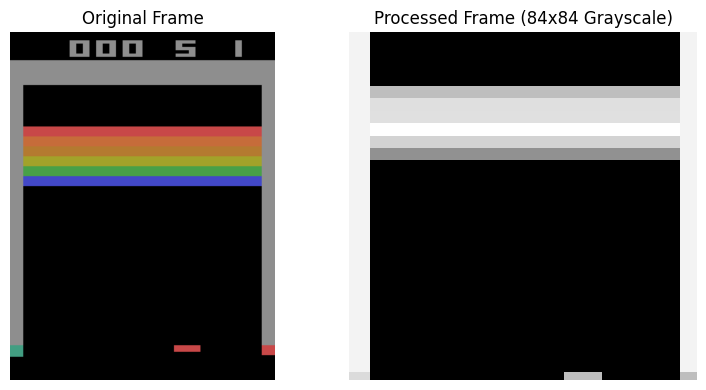

In [8]:
obs, info = env.reset()
processed = preprocess_frame(obs)
print("Shape of preprocessed frame: " + str(processed.shape))
show_frames(obs, processed)

In [9]:
def setup_logger(log_path, log_name="training_log"):
    os.makedirs(log_path, exist_ok=True)
    log_file = os.path.join(log_path, f"{log_name}.log")

    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s | %(message)s',
        handlers=[
            logging.FileHandler(log_file),
            logging.StreamHandler()  # to print to console as well
        ]
    )
    return logging.getLogger()
logger = setup_logger("logs", "dqn_training")

In [19]:
'''•
The architecture used in the paper (as shown in Figure 1 and detailed in Methods) is as follows:
Input Layer: An 84x84x4 image produced by the preprocessing map.
First Hidden Layer: Convolves 32 filters of 8x8 with a stride of 4 and applies a rectifier nonlinearity (ReLU, i.e., max(0, x)).
Second Hidden Layer: Convolves 64 filters of 4x4 with a stride of 2, followed by a rectifier nonlinearity.
Third Hidden Layer: Convolves 64 filters of 3x3 with a stride of 1, followed by a rectifier nonlinearity.
Final Hidden Layer: A fully-connected layer with 512 rectifier units.
Output Layer: A fully-connected linear layer with a single output for each valid action in the Breakout game. Determine the number of valid actions for Breakout (e.g., move left, move right, fire/no-op).
'''

class DQN(nn.Module):
    def __init__(self, action_dim = 4):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 1024),  # 3136 = 64*7*7
            nn.ReLU(),
            nn.Linear(1024, action_dim)
        )

    def forward(self, x):
        return self.net(x)

In [20]:
'''Stacking Frames:
Stacking the last 4 frames helps the agent:
Detect motion
Estimate object direction/speed
Learn temporal dynamics with a feedforward CNN (instead of needing RNNs)
Questions: Can we use RNNs here to preserve temporal information? Can we use attention for learning temporal dynamics?
'''

class FrameStack:
    def __init__(self, k):
        self.k = k
        self.frames = deque([], maxlen=k)

    def reset(self):
        """Call this at the beginning of an episode"""
        self.frames.clear()

    def append(self, obs):
        self.frames.append(obs)

    def get_stack(self):
        assert len(self.frames) == self.k
        return torch.cat(list(self.frames), dim=0)  # shape: [k, 84, 84]

In [21]:
testFrameStack = FrameStack(4)
a = torch.ones((1, 2, 2))
testFrameStack.append(a)
testFrameStack.append(a)
testFrameStack.append(a)
testFrameStack.append(a)
testOp = testFrameStack.get_stack()

print(testOp.shape)

torch.Size([4, 2, 2])


In [22]:
'''
Replay Buffer
'''
class ReplayBuffer:
    def __init__(self, capacity, seed=None):
        # Initialize the buffer with a fixed capacity
        self.buffer = deque([], maxlen=capacity)
        if seed is not None:
          random.seed(seed)

    def push(self, experience):
        # Push an experience into the buffer
        self.buffer.append(experience)

    def sample(self, batch_size):
        # Sample a random mini-batch from the buffer
        return random.sample(self.buffer, batch_size)

    def size(self):
        # Return the current size of the buffer
        return len(self.buffer)

In [23]:
class Agent:
  def __init__(self, experiment_name, hyperparams, action_space_size, device, chkpt=None):
    self.hyperparams = hyperparams

    self.experiment_name = experiment_name
    self.device = device
    self.action_space_size = action_space_size

    # Extract hyperparameters
    self.epsilon = self.hyperparams.EPSILON_START
    self.max_steps = self.hyperparams.MAX_TIMESTEPS
    self.epsilon_end = self.hyperparams.MIN_EPSILON
    self.epsilon_decay_steps = self.hyperparams.EPSILON_DECAY_STEPS
    self.buffer_size = self.hyperparams.BUFFER_SIZE
    self.state_dim = self.hyperparams.STATE_DIM
    self.lr = self.hyperparams.LR
    self.batch_size = self.hyperparams.BATCH_SIZE
    self.gamma = self.hyperparams.GAMMA
    self.num_episodes = self.hyperparams.NUM_EPISODES
    self._epsilonsFirst = np.linspace(self.epsilon, self.epsilon_end, self.epsilon_decay_steps)
    #self._epsilonsSecond = np.linspace(self.epsilon_end, 0, self.epsilon_decay_steps)
    self.epsilons = self._epsilonsFirst
    self.total_grad_update_steps = 0
    self.update_freq = self.hyperparams.UPDATE_FREQ
    self.target_update_freq = self.hyperparams.TARGET_UPDATE
    self.total_env_steps = 0
    self.min_buffer_size = self.hyperparams.MIN_BUFFER_SIZE
    self.max_ep_len = self.hyperparams.MAX_EPISODE_LENGTH
    self.max_noOpCnt = 30

    # Replay buffer
    self.replay_buffer = ReplayBuffer(self.buffer_size, self.hyperparams.SEED)

    # Q-network and target network
    
    self.q_network = DQN(action_space_size).to(device)
    self.target_network = DQN(action_space_size).to(device)
    if(chkpt):
        print(f"Loading saved checkpoint.....{chkpt}")
        self.q_network.load_state_dict(torch.load(chkpt, map_location=device))
        self.target_network.load_state_dict(torch.load(chkpt, map_location=device))
    self.update_target_network()

    # Optimizer and loss
    self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=self.lr)
    self.loss_fn =  nn.HuberLoss()

  def update_target_network(self):
    self.target_network.load_state_dict(self.q_network.state_dict())

  def epsilon_greedy_action(self, state):
    if random.random() < self.epsilon:
        return random.randint(0, self.action_space_size - 1)
    else:
        with torch.no_grad():
            return self.q_network(state).argmax().item()

  def greedy_action(self, state):
    with torch.no_grad():
        return self.q_network(state).argmax().item()

  def run(self, env, training=True):
    episode_rewards = []
    epsilons=[]
    losses=[]
    episode_lengths = []
    frame_stack = FrameStack(self.hyperparams.FRAME_STACK)
    best_avg_reward = -float('inf')
    episode=0
    while self.total_env_steps < self.max_steps:
        obs, info = env.reset()
        state = preprocess_frame(obs)
        frame_stack.reset()

        # Push in the stack until it grows till frame stack size
        for _ in range(self.hyperparams.FRAME_STACK):
            frame_stack.append(state)
        state_stack = frame_stack.get_stack()

        total_reward = 0
        done = False

        ep_len = 0
        curr_life=5
        episode+=1
        life_lost = False
        
        while ep_len <= self.max_ep_len:    
            
            if life_lost or ep_len == 0:
                obs, _, _, _, info = env.step(1)
                preprocessed = preprocess_frame(obs)
                frame_stack.append(preprocessed)
                state_stack = frame_stack.get_stack()
                life_lost = False
                
            state_tensor = state_stack.clone().detach().float().unsqueeze(0).div(255.0).to(self.device)
            action = self.epsilon_greedy_action(state_tensor)
            
            
            next_obs, reward, done, truncated, info = env.step(action)
            
            if info['lives']<curr_life:
                life_lost = True
                curr_life=info['lives']
                
            ep_len += 1
            self.total_env_steps += 1

            next_state = preprocess_frame(next_obs)
            frame_stack.append(next_state)
            next_state_stack = frame_stack.get_stack()

            if training:
              self.replay_buffer.push((state_stack, action, reward, next_state_stack, done or life_lost))
              if self.replay_buffer.size() < self.min_buffer_size:
                self.epsilon = self.hyperparams.EPSILON_START  # ensure full exploration
                if self.replay_buffer.size() % 10000 == 0:
                    print(f"Populating Replay Buffer... Num Steps: {self.total_env_steps}")
                state_stack = next_state_stack
                continue  # skip training step, but continue the episode
              if self.total_env_steps % self.update_freq == 0:
                #print(f"Total Env Steps: {self.total_env_steps}")
                #print("Gradient decent on Q Network")
                self.train_step()
                self.epsilon = self.epsilons[min(self.total_env_steps, self.epsilon_decay_steps-1)]

            state_stack = next_state_stack
            total_reward += reward

            if training and self.total_env_steps % self.target_update_freq == 0:
              print(f"Total Env Steps: {self.total_env_steps}")
              print("Updating Target Network")
              self.update_target_network()
             
            if done:
              break

        if self.total_env_steps>0 and self.total_env_steps%2000000 == 0:
            print(f"Saving Checkpoint Steps: [{self.total_env_steps}]")
            self.save_model(f"qnetwork_chkpt_{self.total_env_steps}.pth")
        

        episode_rewards.append(total_reward)
        epsilons.append(self.epsilon)
        episode_lengths.append(ep_len)
        
        if episode>0 and episode%100==0:
            print(f"Env Steps: {self.total_env_steps}, Episode: {episode}")
            avgRe=np.mean(episode_rewards[-100:])
            avgLen = np.mean(episode_lengths[-100:])
            print(f"Average 100 Episode Reward: {avgRe:.2f}, Epsilon: {self.epsilon:.3f}, Average 100-Episode Length: {avgLen:.2f}")
            print(f"Total Steps: {self.total_env_steps}")
            
       
        if episode % 500 == 0:
            avg_100 = np.mean(episode_rewards[-100:])
            print(f"[Episode {episode}] Average 100-episode reward: {avg_100:.2f}")
            if avg_100 > best_avg_reward:
                best_avg_reward = avg_100 
                print("Saving Best Model...")
                self.save_model(f"qnetwork_{self.experiment_name}_best.pth")
    
        log_data = {
                    'rewards': episode_rewards,
                    'episode_length': episode_lengths,
                    'epsilons': epsilons,
                }
        #Save the logs at every 500 steps
        if episode%1000 == 0:
            print("Saving logs")
            with open('training_stats.jsonl', 'w') as f:
                f.write(json.dumps(log_data) + "\n")
    return self.q_network, episode_rewards, epsilons, episode_lengths

  def train_step(self):
    batch = self.replay_buffer.sample(self.batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)
    states = torch.stack(states).to(self.device)              # [B, 4, 84, 84]
    next_states = torch.stack(next_states).to(self.device)    # [B, 4, 84, 84]

    #Convert the stacked frames from uint8 to float32, normalize the image
    states = states.clone().detach().float().div(255.0).to(self.device) # [B, 4, 84, 84]
    next_states = next_states.clone().detach().float().div(255.0).to(self.device) # [B, 4, 84, 84]

    actions = torch.tensor(actions).long().unsqueeze(1).to(self.device)  # [B, 1]
    rewards = torch.tensor(rewards).float().unsqueeze(1).to(self.device) # [B, 1]
    dones = torch.tensor(dones).float().unsqueeze(1).to(self.device)     # [B, 1]

    q_values = self.q_network(states)
    next_q_values = self.target_network(next_states)

    q_value = q_values.gather(1, actions) #Index the q value based on the action taken

    next_q_value = next_q_values.max(1)[0].unsqueeze(1)
    target = rewards + self.gamma * next_q_value * (1 - dones) #If the episode is over, reward is 0

    loss = self.loss_fn(q_value, target.detach())
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
    self.total_grad_update_steps += 1


  def evaluate(self, env, num_episodes=5, render=False, debug=False):
    frame_stack = FrameStack(self.hyperparams.FRAME_STACK)
    total_rewards = []

    for _ in range(num_episodes):
        obs, info = env.reset()
        state = preprocess_frame(obs)
        frame_stack.reset()
        for _ in range(self.hyperparams.FRAME_STACK):
            frame_stack.append(state)

        state_stack = frame_stack.get_stack()
        episode_reward = 0
        done = False
        step_cnt=0
        curr_life=5
        epLen=0
        life_lost=False
        while not done:
            if life_lost or epLen == 0:
                obs, _, _, _, info = env.step(1)
                preprocessed = preprocess_frame(obs)
                frame_stack.append(preprocessed)
                state_stack = frame_stack.get_stack()
                life_lost = False
            epLen+=1
            state_tensor = torch.tensor(state_stack, dtype=torch.float32).unsqueeze(0).div(255.0).to(self.device)
            action = self.greedy_action(state_tensor)
            next_obs, reward, done, truncated, info = env.step(action)
            if info['lives']<curr_life:
                life_lost = True
                curr_life=info['lives']
            if(step_cnt==30000):
                break
            if(debug):
                print(f"Step: {step_cnt}, Action: {action}, Reward: {reward}, Info: {info}")            
            if render:
                env.render()
            next_state = preprocess_frame(next_obs)
            frame_stack.append(next_state)
            state_stack = frame_stack.get_stack()
            episode_reward += reward
            step_cnt+=1

        total_rewards.append(episode_reward)

    avg_reward = np.mean(total_rewards)
    #logger.info(f"Episode {num_episodes}, Reward: {avg_reward}")
    print(f"Episode {num_episodes}, Reward: {avg_reward}")
    return avg_reward

  def save_model(self, path):
    torch.save(self.q_network.state_dict(), path)

  def load_model(self, path):
    self.q_network.load_state_dict(torch.load(path))
    self.q_network.eval()

In [24]:
class HyperParams:
    def __init__(self):
        # Replay buffer
        self.BUFFER_SIZE = int(500000)  # 1000,000 experiences  reducing it to 500000
        self.MIN_BUFFER_SIZE = int(50000)
        self.BATCH_SIZE = 32         # Mini-batch size

        # Epsilon-greedy exploration
        self.EPSILON_START = 1     # Initial epsilon 
        #No epsilon decay for the second phase training v-7
        self.EPSILON_DECAY_STEPS = 1000000
        self.MIN_EPSILON = 0.1

        # Target network update frequency
        self.TARGET_UPDATE = 10000    # Sync target network every 100 steps

        # Learning rate
        self.LR = 0.0001            # Learning rate (alpha)

        # Discount factor
        self.GAMMA = 0.99            # Discount factor (gamma)

        # Frame stack & environment
        self.FRAME_STACK = 4
        self.STATE_DIM = (self.FRAME_STACK, 84, 84)  # Input to CNN

        # Training control
        self.NUM_EPISODES = 10000
        self.MAX_TIMESTEPS = 8000000 
        self.MAX_EPISODE_LENGTH = 20000

        self.UPDATE_FREQ = 4

        # Misc
        self.SEED = 42               # For reproducibility

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
hyperparams=HyperParams()

In [27]:
device

device(type='cpu')

In [28]:
experiment_name="v21_gpu_lifeLostMarkEnd"
dqn_agent = Agent(experiment_name=experiment_name, 
                  hyperparams=hyperparams, 
                  action_space_size=4,
                  device=device)

In [29]:
print(dqn_agent.q_network)

DQN(
  (net): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=3136, out_features=1024, bias=True)
    (8): ReLU()
    (9): Linear(in_features=1024, out_features=4, bias=True)
  )
)


In [22]:
gym.register_envs(ale_py)
env = gym.make("ALE/Breakout-v5", render_mode = "rgb_array")

In [ ]:
network, rewards, epsilons, episode_lengths =  dqn_agent.run(env, training=True)

In [30]:

import matplotlib.pyplot as plt

def plot(rewards, epsilons, episode_lengths):
    plt.figure(figsize=(12, 5))

    plt.plot(rewards, color = 'red')
    plt.title('Episode Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.show()
    plt.savefig('rewards.png')
    
    plt.figure(figsize=(12, 5))
    plt.plot(epsilons, color = 'green')
    plt.title('Epsilon')
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.show()
    plt.savefig('epsilon.png')

    plt.figure(figsize=(12, 5))
    plt.plot(episode_lengths, color = 'blue')
    plt.title('Episode Lengths')
    plt.xlabel('Episode')
    plt.ylabel('Episode Length')
    plt.show()
    plt.savefig('eplen.png')
    
    plt.close()

In [24]:
# plot_rewards(rewards, epsilons, episode_lengths)

### Inference and plots

In [25]:
# rewards = []
# episode_length = []
# epsilons = []
# data = []
# with open(TRAINING_STATS, 'r') as f:
#     for line in f:
#         data.append(json.loads(line))
# rewards = data[-1]['rewards']
# episode_length = data[-1]['episode_length'][1:]
# epsilons = data[-1]['epsilons']

# data = []
# with open(TRAINING_STATS2, 'r') as f:
#     for line in f:
#         data.append(json.loads(line))
# rewards.extend(data[-1]['rewards'])
# episode_length.extend(data[-1]['episode_length'][1:])
# epsilons.extend(data[-1]['epsilons'])

In [ ]:
# print(len(rewards))

In [ ]:
plot(rewards[1:], epsilons[1:], episode_lengths[1:])

## Analysis of results

In [31]:
TRAINING_STATS= "/kaggle/input/dqn-8k-run/training_stats.jsonl"
MODEL_CHKPT= "/kaggle/input/dqn-8k-run/qnetwork_v21_gpu_lifeLostMarkEnd_best.pth"
# MODEL_CHKPT_2000= "/kaggle/input/dqn-first4k-run/qnetwork_chkpt_2000.pth"

# MODEL2_CHKPT = "/kaggle/input/deep-q-learning-breakout/qnetwork_v7_best.pth" 
# TRAINING_STATS2="/kaggle/input/deep-q-learning-breakout/training_stats.jsonl"

In [32]:
rewards = []
episode_length = []
epsilons = []
data = []
with open(TRAINING_STATS, 'r') as f:
    for line in f:
        line=json.loads(line)
        rewards = line['rewards']
        episode_length = line['episode_length']
        epsilons = line['epsilons']

print(len(rewards), len(episode_length), len(epsilons))

9000 9000 9000


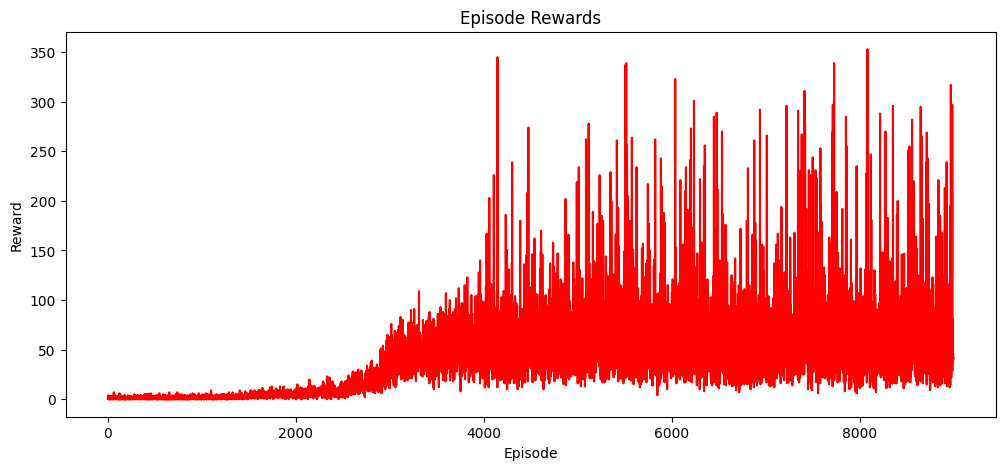

<Figure size 640x480 with 0 Axes>

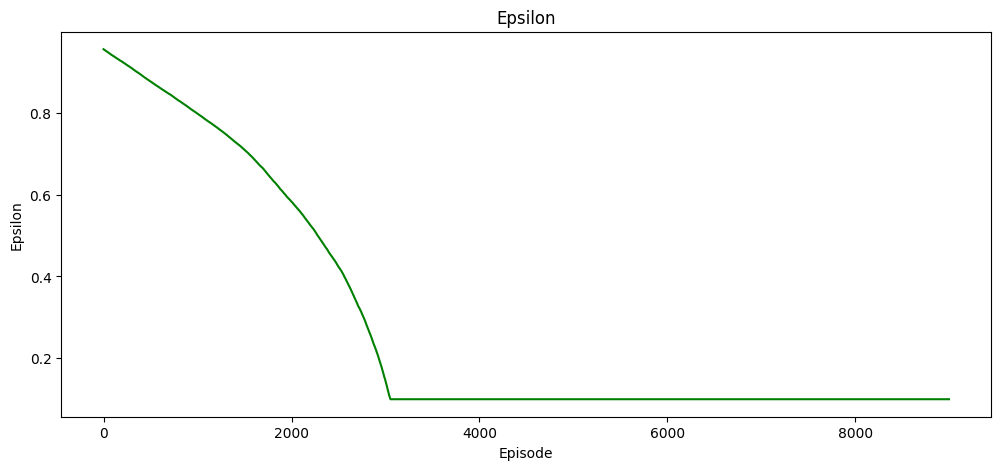

<Figure size 640x480 with 0 Axes>

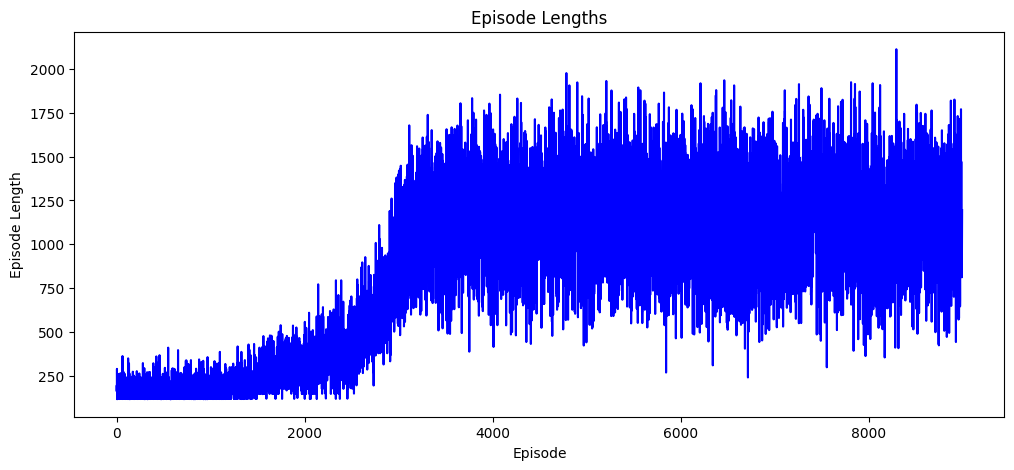

In [33]:
plot(rewards[3:], epsilons[3:], episode_length[3:])

In [34]:
inference_agent_best = Agent(experiment_name="inference", 
                  hyperparams=hyperparams, 
                  action_space_size=4,
                  device=device,
                  chkpt = MODEL_CHKPT)

Loading saved checkpoint...../kaggle/input/dqn-8k-run/qnetwork_v21_gpu_lifeLostMarkEnd_best.pth


In [35]:
gym.register_envs(ale_py)
env = gym.make("ALE/Breakout-v5", render_mode = "rgb_array")

In [36]:
run=1

In [37]:

env = rl.RenderFrame(env, f"output/final_sampling/{run}")
inference_agent_best.evaluate(env, num_episodes=1, debug=False)
env.play()
run+=1

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


Episode 1, Reward: 51.0
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


In [38]:

avg_100_ep_rewards = [] 
avg_100_ep_len = []
n =  len(episode_length[3:])
filtered_rew=rewards[3:]
filtered_len=episode_length[3:]
for i in range(0, n-100, 100):
    avg_100_ep_rewards.append(np.mean(filtered_rew[i:i+100]))
    avg_100_ep_len.append(np.mean(filtered_len[i:i+100]))

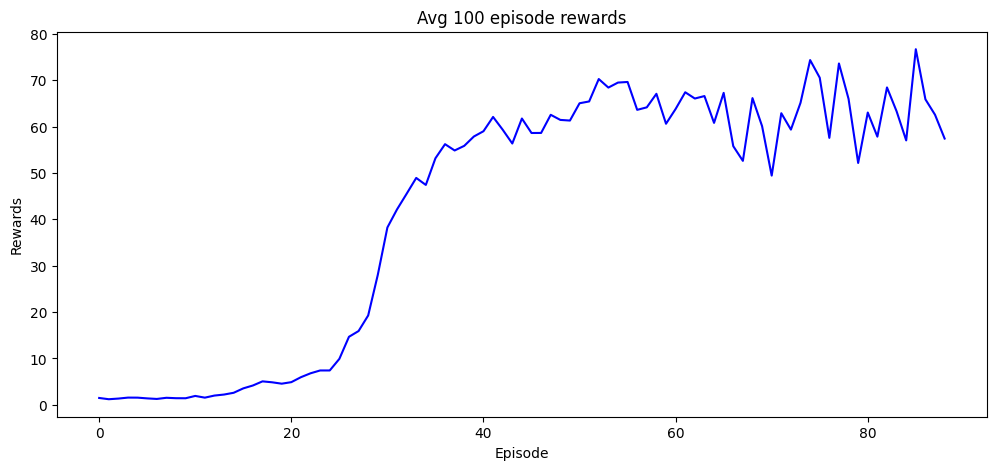

<Figure size 640x480 with 0 Axes>

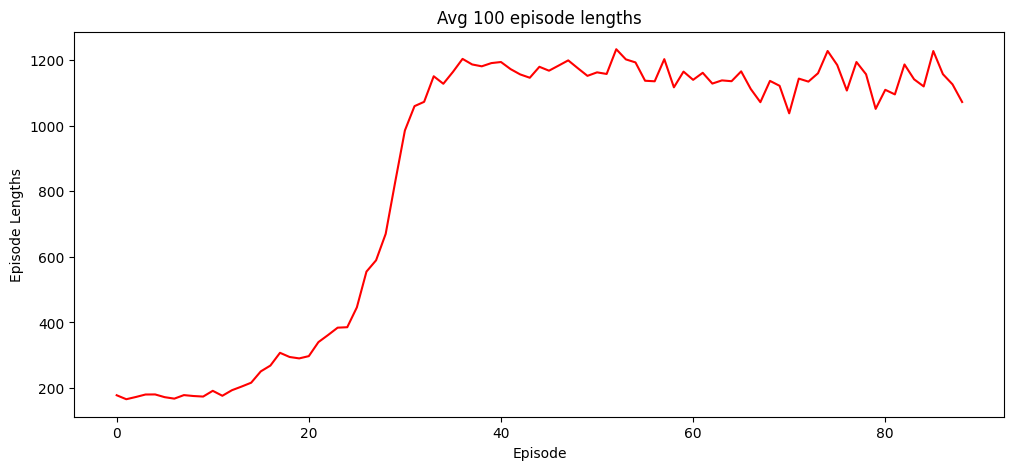

<Figure size 640x480 with 0 Axes>

In [33]:
plt.figure(figsize=(12, 5))
plt.plot(avg_100_ep_rewards, color = 'blue')
plt.title('Avg 100 episode rewards')
plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.show()
plt.savefig('avg_rewards.png')

plt.figure(figsize=(12, 5))
plt.plot(avg_100_ep_len, color = 'red')
plt.title('Avg 100 episode lengths')
plt.xlabel('Episode')
plt.ylabel('Episode Lengths')
plt.show()
plt.savefig('avg_lengths.png')

In [39]:
max_100_ep_rewards = [] 
max_100_ep_len = []
n =  len(episode_length[3:])
filtered_rew=rewards[3:]
filtered_len=episode_length[3:]
for i in range(0, n-100, 100):
    max_100_ep_rewards.append(np.max(filtered_rew[i:i+100]))
    max_100_ep_len.append(np.max(filtered_len[i:i+100]))

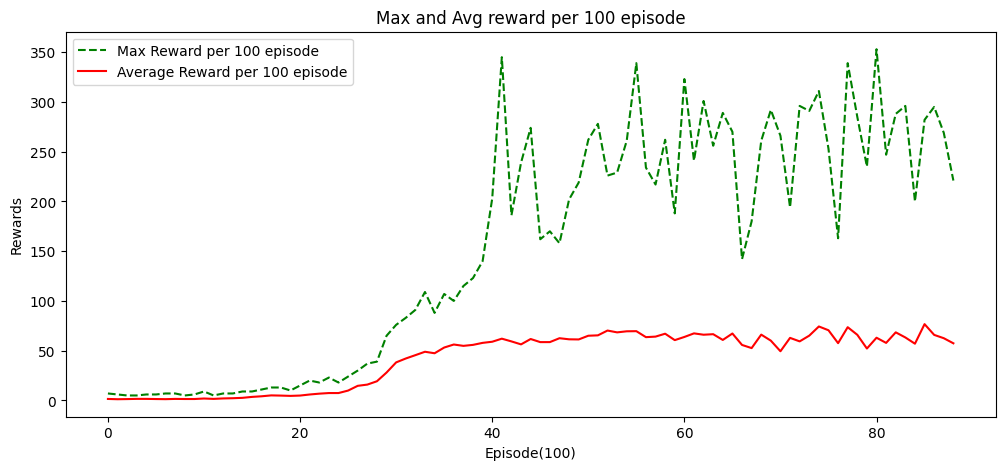

<Figure size 640x480 with 0 Axes>

In [41]:
plt.figure(figsize=(12, 5))
plt.plot(max_100_ep_rewards, linestyle = '--', color = 'green', label='Max Reward per 100 episode')
plt.plot(avg_100_ep_rewards, linestyle = '-', color = 'red', label='Average Reward per 100 episode')
plt.title('Max and Avg reward per 100 episode')
plt.xlabel('Episode(100)')
plt.ylabel('Rewards')
plt.legend()
plt.show()
plt.savefig('max_avg_rewards.png')

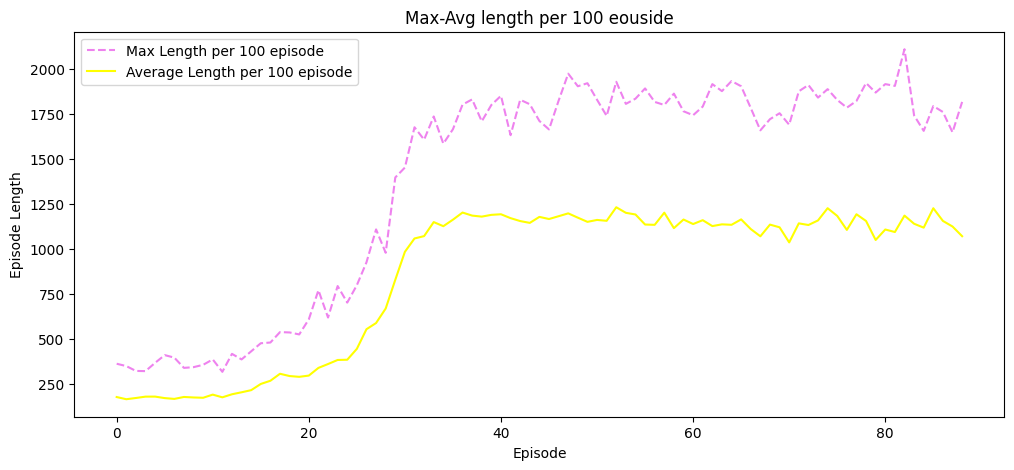

<Figure size 640x480 with 0 Axes>

In [41]:
plt.figure(figsize=(12, 5))
plt.plot(max_100_ep_len, linestyle = '--', color = 'violet', label='Max Length per 100 episode')
plt.plot(avg_100_ep_len, linestyle = '-', color = 'yellow', label='Average Length per 100 episode')
plt.title('Max-Avg length per 100 episode')
plt.xlabel('Episode')
plt.ylabel('Episode Length')
plt.legend()
plt.show()
plt.savefig('max_avg_length.png')